# LangChain Retrieval Augmented Generation Example 1

[Build a Retrieval Augmented Generation (RAG) App: Part 1](https://python.langchain.com/docs/tutorials/rag/)

Introduce the basic components of a RAG system and how they should be connected, including 
* document loader, 
* document splitter, 
* embedding model, 
* LLM model, 
* vector store,
* LangChain workflow
    * query analysis step
    * document retrieval
    * generator

In [3]:
import dotenv
import sys
from pathlib import Path

## Setup Environment
sys.path.append(Path.cwd().parent) # Append project home to system path
dotenv.load_dotenv() # Load .env

True

## Construct LLM

In [4]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

In [5]:
# LLM
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

# Embeding
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## Get Documents

In [6]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


## Split Documents 

The RecursiveCharacterTextSplitter is a text splitting utility provided by LangChain designed to break down long documents into smaller, manageable chunks while trying to preserve semantic coherence. It recursively splits the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

The algorithm begins by trying to split the text using the largest or most meaningful separator (for example, a double newline or paragraph break). If a chunk is still too long, it recursively applies smaller separators (such as single newline characters, punctuation, or even individual characters) until the chunks meet the desired length.


In [8]:
# Split document using RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
all_splits[:5]

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

## Store Documents

Document chunk are stored in the vector database. 

Each document chunk consists of content and metadata. By default, the metadata contains the `source` for the original document of the chunk. We can also add other metadata to document chunk. For example, here we add the position of the chunk in the document.

In [33]:
## Attach metadata to the document
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[2].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

Add document chunks into the vector store. 

Here we used an in-memory vector datastore for demonstration purposes.

In [48]:
# vector store
vector_store = InMemoryVectorStore(embeddings)

In [49]:
# Index chunks
document_ids = vector_store.add_documents(documents=all_splits)

print("Total documents: %d" % (len(vector_store.store)))
print("Top three document IDs: %s" % (str(document_ids[:3])))
print("Example document: %s" % (str(vector_store.get_by_ids([document_ids[1]]))))

Total documents: 66
Top three document IDs: ['78382b8e-4320-47a1-95bc-70e3c215868d', '5fc67bcb-4fab-4cc1-91bc-30a4a31cdcd0', '28e12b5d-cf79-42e1-beb9-894f7495b923']
Example document: [Document(id='5fc67bcb-4fab-4cc1-91bc-30a4a31cdcd0', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}, page_content='Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.')]


## RAG Chain

Retrieve and Generation

### Query Analysis Step

Query analyzing is a useful step. It ananlyzes the user input question using LLM and generates a structured RAG queries to help retrieval.  
For example, some user input questions are multifaceted, including irrelavent context, or with filters. These questions need to be analyzed and rewritten for the RAG system to more accurate retrieval. For input question with filters, such as "Find document since year 2020", the year element is extracted by the query analyzer, and is evaluated as filter to only select documents published after 2020 to query. 

A few key points to implementation of a query analysis step.
* Define the a structured `Search` object using `TypeDict` and `Annotated` typed fields.
* The use of `Annotated` is purely for documentation or external tools—it doesn't change runtime behavior but helps guide LLM outputs. 
* The annotation is the query which LLM uses to extract and populate the fields.
* THe function `llm.with_structured_output(Search)` modifies the behavior of the LLM so that it generates output conforming to the Search schema. Instead of returning a free-text response, the LLM formats the response as a dictionary matching `Search`.

Note: Multifacted query example - can you help me find information on the latest trends in artificial intelligence, including recent research papers, key industry players, and potential ethical concerns?


In [50]:
from typing import Literal
from typing_extensions import Annotated

In [51]:
# Define search query
class Search(TypedDict):
    """Search query. Field annotation are used by the LLM to populate value."""
    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

In [76]:
# Define analyze query step
def analyze_query(state: State):
    """Use LLM to analyze the user question and populate a `Search` object based on the annotation of each field."""
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

### Retrieval Step

Use LangGraph to create the Retrieval-Generation chain. LangGraph provides an integrated method to build business logic into a workflow. It also allows human-in-the-loop. To use LangGraph, we need to define three things:
* The State of our application;
* The steps of our application;
* The workflow of our application.


In [53]:
from langgraph.graph import StateGraph, START, END

In [71]:
# Define application steps
def retrieve(vector_store: InMemoryVectorStore):
    """The retrieve function takes the current application state and performs a similarity 
    search on a vector store using the question provided in the state. It collects relevant 
    documents based on semantic similarity. The function then returns these documents as 
    context for further processing."""
    def _retrieve(state: State):
        query = state['query']
        retrieved_docs = vector_store.similarity_search(
            query["query"],
            filter=lambda doc: doc.metadata.get("section") == query["section"],
        )
        return {"context": retrieved_docs}
    return _retrieve

### Generation Step

At the generation step, the RAG system stitch the retrieved context information with rewritten questions for generation.

Pre-defined prompts can be pulled from Langchain Hub. 

In [68]:
# Load a simple generation prompt
prompt = hub.pull("rlm/rag-prompt")

# Print out the prompt
example_messages = prompt.invoke(
    {
        "context": "(context goes here)",
        "question": "(question goes here)"
    }
).to_messages()
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Alternatively generation prompt can also be defined by users.

In [57]:
# Alternatively the prompt template can be loaded from user-defined
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

Define the generation step.

In [58]:
def generate(state: State):
    """The generation function concatenates the content of the retrieved documents from the 
    state into a single text block. It then creates a prompt using the question and the 
    compiled context, and passes this prompt to a language model for response generation. 
    Finally, it extracts and returns the generated answer.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

### Build RAG Chain and Invoke

This code chunk builds a workflow graph for the application. It creates a state-based graph using the State type and adds the retrieve and generate functions in sequence, establishing the order of operations. An edge is then added from a designated start node to the retrieve step, setting the entry point of the workflow. Finally, the graph is compiled into an executable structure that orchestrates the application's logic.

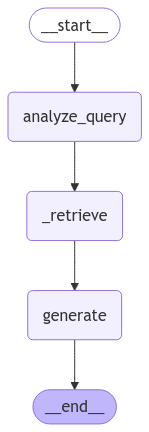

In [72]:
from IPython.display import Image, display

# Compile a simple RAG system
graph_builder = StateGraph(State) # Start a graph builder
graph_builder.add_sequence([
    analyze_query, 
    retrieve(vector_store), 
    generate
]) # Add nodes
graph_builder.add_edge(START, "analyze_query") # Build graph
graph_builder.add_edge("generate", END) # Build graph
graph = graph_builder.compile() # Compile

# Display the application
display(Image(graph.get_graph().draw_mermaid_png()))

In [73]:
# Invoke a LangGraph
# The invoke mode outputs all steps and output all outputs at once after the last step is executed.
response = graph.invoke({"question": "What does the end of the post say about Task Decomposition?"})

print(response["context"], "\n\n")
print(response["answer"])

[Document(id='33414b9f-65b3-4635-a84b-476c4d19a2fe', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\nThen you will output the content of each file including ALL code.\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\nFILENAME is the lowercase file name including the file extension,\nLANG is the markup code block language for the code’s language, and CODE is the code:\nFILENAME\nCO

In [74]:
# Stream updates a LangGraph
# The stream mode execute the application steps one by one and output after each step.
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"}, 
    stream_mode="updates"
):
    print(f"{step}\n\n-----------------------------\n")


{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

-----------------------------

{'_retrieve': {'context': [Document(id='33414b9f-65b3-4635-a84b-476c4d19a2fe', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\nThen you will output the content of each file including ALL code.\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\nFILENAME is the lowercase fi

In [75]:
# Stream tokens
for message, metadata in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"}, 
    stream_mode="messages"
):
    print(message.content, end="|")

|{"|query|":"|Task| De|composition|","|section|":"|end|"}|||||The| end| of| the| post| emphasizes| that| Task| De|composition| involves| thoroughly| planning| and| detailing| the| architecture| before| implementation|.| It| suggests| method|ically| identifying| core| classes|,| functions|,| and| files|,| and| ensuring| that| every| aspect| is| fully| coded| without| placeholders|.| Additionally|,| it| highlights| the| importance| of| following| best| practices| for| file| naming| and| organization|,| and| ensuring| all| parts| of| the| architecture| are| compatible| and| well|-d|ocumented|.||

## References

[LangGraph](https://langchain-ai.github.io/langgraph/)